In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [3]:
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import jaccard_score, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

from imblearn.pipeline import Pipeline, make_pipeline

from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.impute import SimpleImputer

In [4]:
data = pd.read_csv("./cervical-cancer.csv")

# Business introduction

Cervical cancer is the fourth most frequent type of woman's cancer worldwide (after breast, colorectal and lung cancers). As claimed by the World Health Organisation, over 570 thousand new cases were diagnosted in 2018 representing 6.6% of all female cancers. Approximately 90% of deaths from cervical cancer occurred in low and middle-income countries. The high death rate from cervical cancer could be reduced through a comprehensive approach that includes prevention, early diagnosis, effective screening and treatment programmes. There are currently vaccines that protect against common cancer-causing types of human papilloma virus (HPV) and can significantly reduce the risk of cervical cancer.

Particularly in countries where screening programmes are not available, diagnosing cervical cancer at an early stage and providing access to effective treatment can significantly improve the chance of survival. Currently, the disease is often not identified until it is further advanced or treatment is inaccessible resulting in a higher rate of death from cervical cancer. Understanding and detecting symptoms of cervical cancer is crucial for decreasing the mortality rate caused by the disease.

Symptoms of cervical cancer may include: irregular or abnormal vaginal bleeding after sexual intercourse, back, leg or pelvic pain; fatigue, weight loss, loss of appetite. More severe symptoms may arise at advanced stages.

One of the most effective and common tests allowing to diagnose cervical cancer is biopsy - procedure to remove tissue from the cervix to test for abnormal or precancerous conditions (including cervix cancer). Cervical biopsies can be done in several ways. The biopsy can remove a sample of tissue for testing. It can also be used to completely take out abnormal tissue. It can also treat cells that may turn into cancer. Biopsy has 97-99% sensivity, which means that for approximately 98% of the afflicted the test will turn positive.

As cervical cancer along sexually transmitted diseases or biopsy itself is often embarrassing topic in society, there is a need to provide a method to predict what types of people have greater probability of developing a cancer. Trying to accomplish that, we will build a Machine Learning model which predicts medic's decision whether patient requires biopsy or not.

To reach this goal, we will use dataset cervical-cancer available at https://datahub.io/machine-learning/cervical-cancer. The dataset contains information about over 800 patients. Based on that data we will construct as best model solving this classification problem.

# Exploratory data analysis

As first step of our analysis, we will take a look at distribution of features:

In [5]:
data.describe()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,835.000000,810.000000,828.000000,779.000000,822.000000,822.000000,822.000000,732.000000,732.000000,723.000000,...,71.000000,71.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000
mean,27.023952,2.551852,17.020531,2.304236,0.149635,1.253850,0.465823,0.651639,2.302916,0.114799,...,6.140845,5.816901,0.021557,0.010778,0.021557,0.028743,0.041916,0.087425,0.051497,0.064671
std,8.482986,1.676686,2.817000,1.455817,0.356930,4.140727,2.256273,0.476777,3.794180,0.319000,...,5.895024,5.755271,0.145319,0.103320,0.145319,0.167182,0.200518,0.282626,0.221142,0.246091
min,13.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,2.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,2.000000,17.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,...,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,3.000000,18.000000,3.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,...,8.000000,7.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,28.000000,32.000000,11.000000,1.000000,37.000000,37.000000,1.000000,30.000000,1.000000,...,22.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There are four features that might be considered as targets: Biopsy, Hinselmann, Schiller and Citology. As claimed we will consider only Biopsy. Take note that all of above are similarly unbalanced.

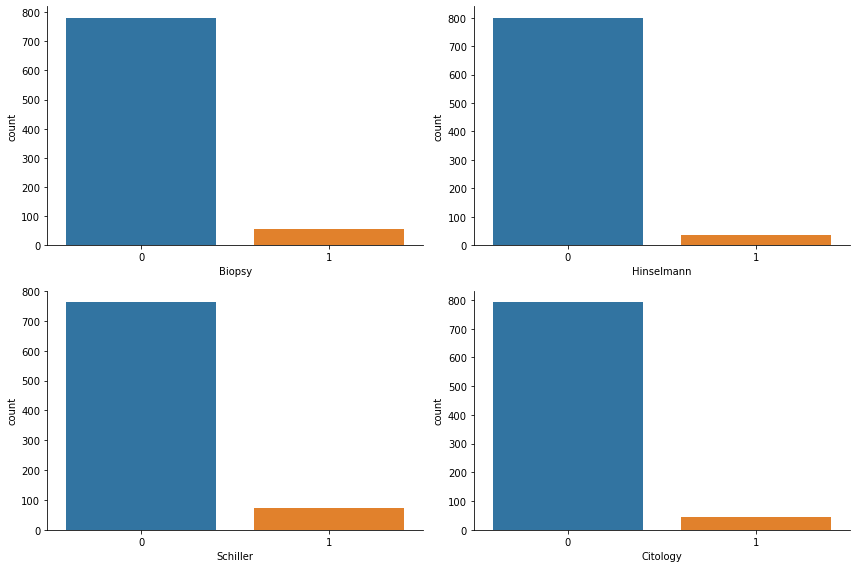

In [6]:
categorical_feat = ['Biopsy', 'Hinselmann', 'Schiller', 'Citology']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    plt.sca(ax)
    ax = sns.countplot(x = categorical_feat[idx], data=data)
sns.despine()
plt.tight_layout()
plt.show()

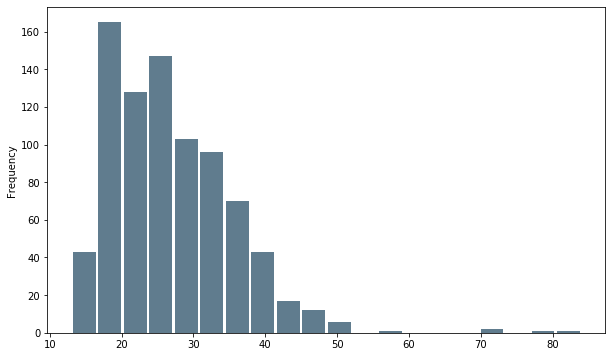

In [7]:
plt.figure(figsize=(10, 6))
data.loc[:,"Age"].plot.hist(grid=False, bins=20, rwidth=0.9,
                   color='#607c8e')

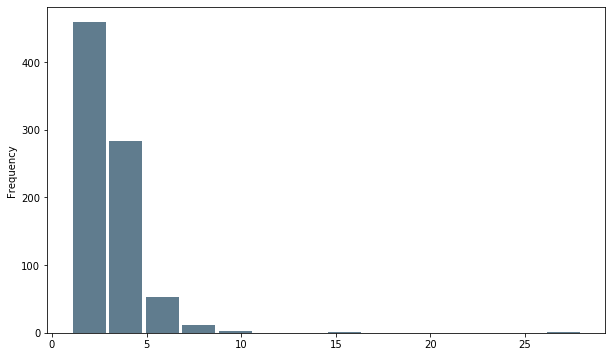

In [8]:
plt.figure(figsize=(10, 6))
data.loc[:,"Number of sexual partners"].plot.hist(grid=False, bins=14, rwidth=0.9,
                   color='#607c8e')

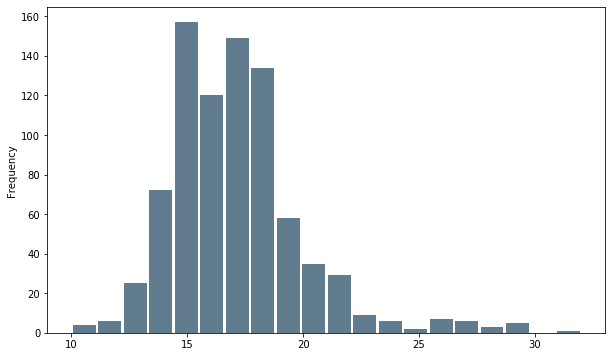

In [9]:
plt.figure(figsize=(10, 6))
data.loc[:,"First sexual intercourse"].plot.hist(grid=False, bins=20, rwidth=0.9,
                   color='#607c8e')

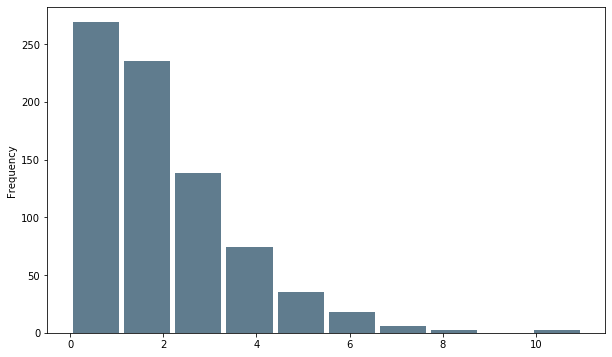

In [10]:
plt.figure(figsize=(10, 6))
data.loc[:,"Num of pregnancies"].plot.hist(grid=False, rwidth=0.9,
                   color='#607c8e')

In [11]:
for col in data.columns:
    if data[col].nunique() == 2:
        data[col] = data[col].astype("bool")
data.dtypes

Age                                     int64
Number of sexual partners             float64
First sexual intercourse              float64
Num of pregnancies                    float64
Smokes                                   bool
Smokes (years)                        float64
Smokes (packs/year)                   float64
Hormonal Contraceptives                  bool
Hormonal Contraceptives (years)       float64
IUD                                      bool
IUD (years)                           float64
STDs                                     bool
STDs (number)                         float64
STDs:condylomatosis                      bool
STDs:cervical condylomatosis          float64
STDs:vaginal condylomatosis              bool
STDs:vulvo-perineal condylomatosis       bool
STDs:syphilis                            bool
STDs:pelvic inflammatory disease         bool
STDs:genital herpes                      bool
STDs:molluscum contagiosum               bool
STDs:AIDS                         

In [12]:
data.drop(["STDs:cervical condylomatosis", "STDs:AIDS"], axis=1, inplace=True) # all NA
data.drop(["STDs: Time since first diagnosis", "STDs: Time since last diagnosis"], axis=1, inplace=True) # 1 unique val

Correlation between boolean features:

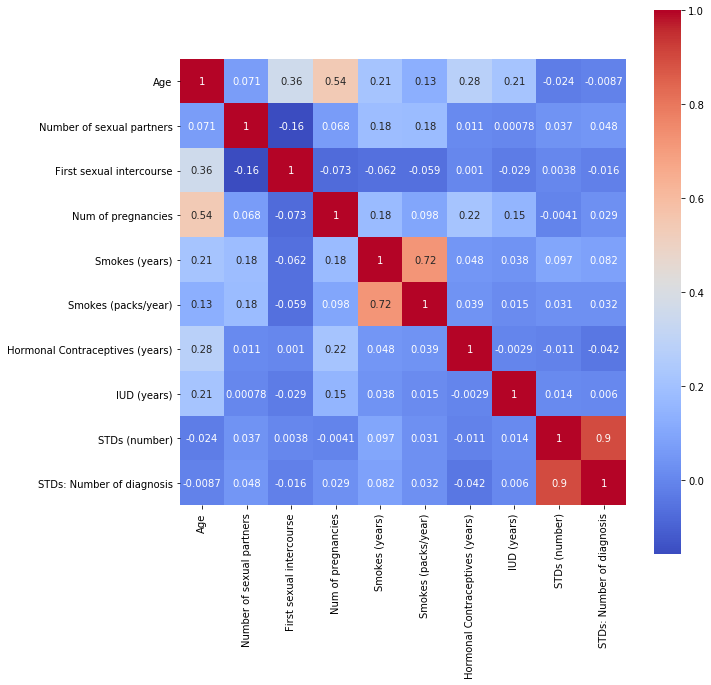

In [13]:
plt.figure(figsize=(10, 10))

sns.heatmap(data.select_dtypes(exclude=['bool']).corr(), annot=True, cmap="coolwarm", square=True)

In [14]:
data_bool = data.select_dtypes(include="bool")

jaccard_matrix = pd.DataFrame(0, index=data_bool.columns, columns=data_bool.columns)


for i in range(len(data_bool.columns)):
    for j in range(len(data_bool.columns)):
        jaccard_matrix.iloc[i, j] = jaccard_score(data_bool.iloc[:, i], data_bool.iloc[:, j])

Since correlation between two binary features can be misleading, here we computed Jaccard score between them 
All STDs feature highly overlap, should remove most of them before modeling.

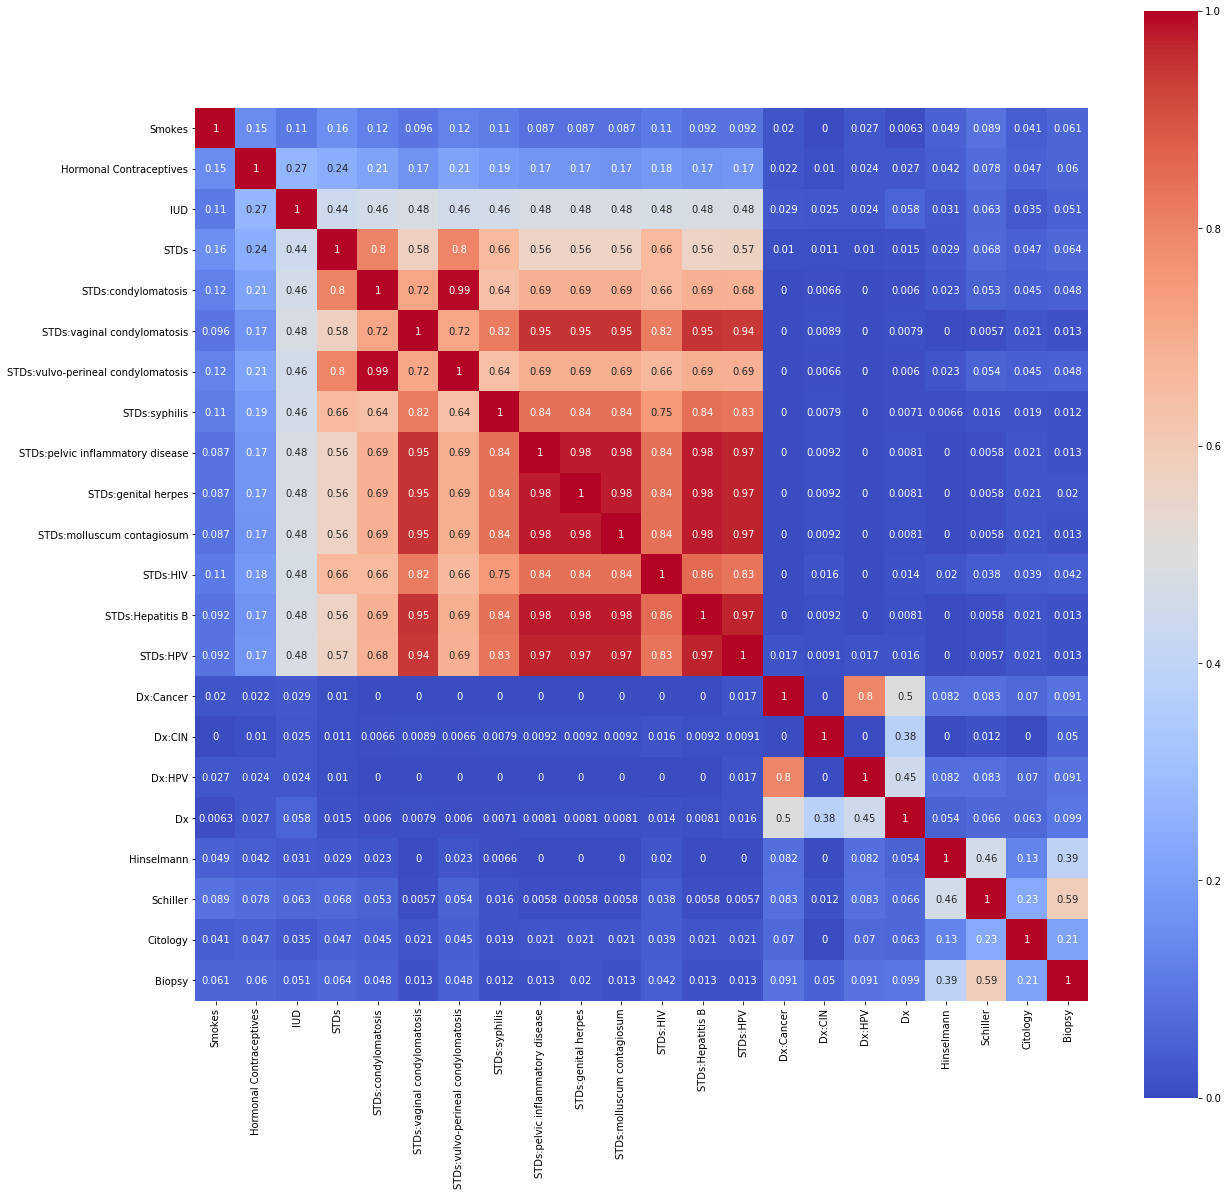

In [15]:
plt.figure(figsize=(20, 20))

sns.heatmap(jaccard_matrix, annot=True, cmap="coolwarm", square=True)

# Feature engineering

In [16]:
data = pd.read_csv("./cervical-cancer.csv")

We need to impute the missing values in the dataset before creating first models. 

In [17]:
data.isna().sum().sort_values(ascending=False)

STDs: Time since last diagnosis       764
STDs: Time since first diagnosis      764
IUD (years)                           112
IUD                                   112
Hormonal Contraceptives               103
Hormonal Contraceptives (years)       103
STDs:molluscum contagiosum            100
STDs                                  100
STDs (number)                         100
STDs:condylomatosis                   100
STDs:cervical condylomatosis          100
STDs:vaginal condylomatosis           100
STDs:vulvo-perineal condylomatosis    100
STDs:pelvic inflammatory disease      100
STDs:genital herpes                   100
STDs:syphilis                         100
STDs:AIDS                             100
STDs:Hepatitis B                      100
STDs:HPV                              100
STDs:HIV                              100
Num of pregnancies                     56
Number of sexual partners              25
Smokes (packs/year)                    13
Smokes (years)                    

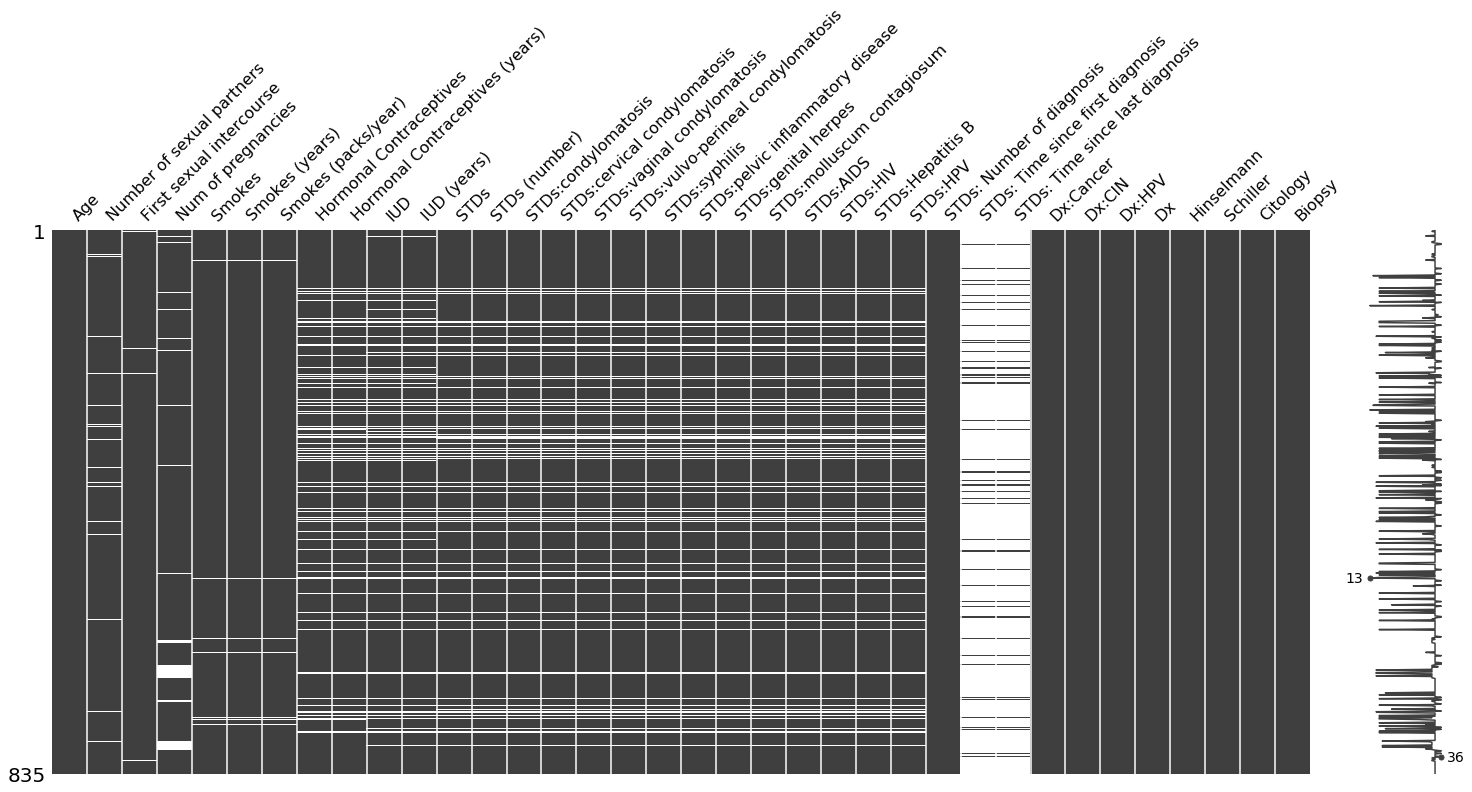

In [18]:
msno.matrix(data)

You can observe that columns **STDs: Time since first diagnosis** and **STDs: Time since last diagnosis**. Moreover columns **STDs:cervical condylomatosis** **STDs:AIDS** have only one unique value each. We will remove them as they don't bring any valuable information to neither analysis nor modelling.

In [19]:
data.drop(["STDs:cervical condylomatosis", "STDs:AIDS"], axis=1, inplace=True) # all NA
data.drop(["STDs: Time since first diagnosis", "STDs: Time since last diagnosis"], axis=1, inplace=True) # 1 unique val

The three possible target features other than biopsy can clearly leek information about wheather biopsy was done as well. The correletion between Hinselmann, Schiller, Citology and biopsy is visible below. Also knowing about biopsy is unnecessary after the pacient underwent any of other tests. That's why we will remove those three columns as well.

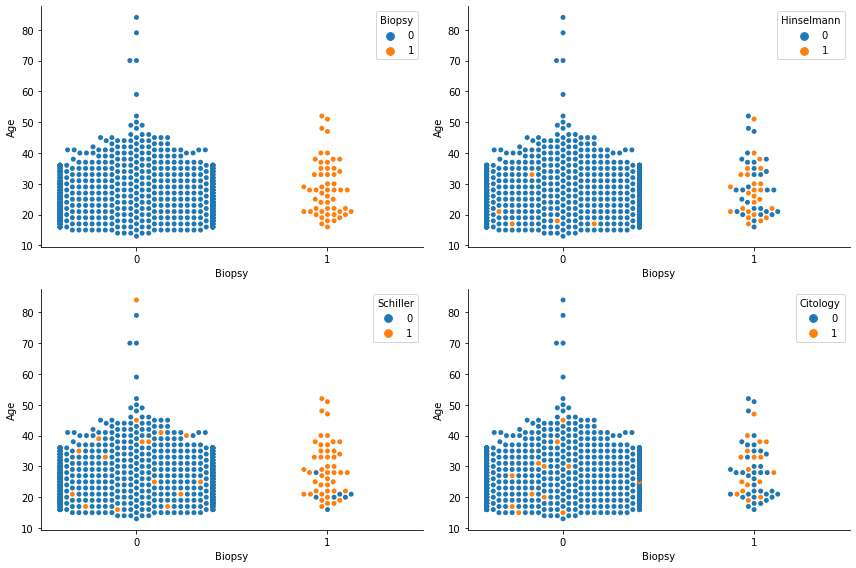

In [20]:
categorical_feat = ['Biopsy', 'Hinselmann', 'Schiller', 'Citology']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    plt.sca(ax)
    ax = sns.swarmplot(x = "Biopsy", hue = categorical_feat[idx], y = "Age", data=data)
sns.despine()
plt.tight_layout()
plt.show()

#  Preprocessing

In [21]:
missing_indicators = data.isnull().astype(int).add_suffix('_indicator')

In [22]:
missing_indicators['Biopsy_'] = data.Biopsy.astype('int')

In [23]:
# Selecting only indicators for columns with missing data
missing_indicators = missing_indicators.loc[:, (missing_indicators != 0).any(axis=0)]

In [24]:
data_with_indicators = pd.concat([data, missing_indicators], axis=1)

In [25]:
data_with_indicators.drop('Biopsy_', axis=1, inplace=True)

In [26]:
data.shape

(835, 32)

In [27]:
data_with_indicators.shape

(835, 54)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("Biopsy", axis=1),
    data["Biopsy"],
    stratify=data["Biopsy"],
    test_size=0.4,
    random_state=42)

In [29]:
X_train_with_indicators, X_test_with_indicators, y_train, y_test = train_test_split(
    data_with_indicators.drop("Biopsy", axis=1),
    data_with_indicators["Biopsy"],
    stratify=data_with_indicators["Biopsy"],
    test_size=0.4,
    random_state=42)

# Model performance

## 1 Base model

In [30]:
pipe = Pipeline([('imputation', SimpleImputer(strategy='most_frequent')),
                 ('classifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1))])

In [31]:
base_rf = pipe.fit(X_train, y_train)

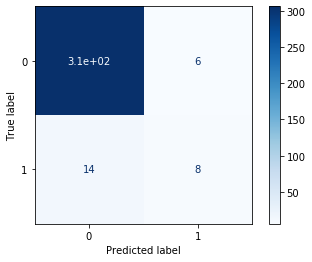

In [32]:
plot_confusion_matrix(base_rf, X_test, y_test, cmap='Blues')

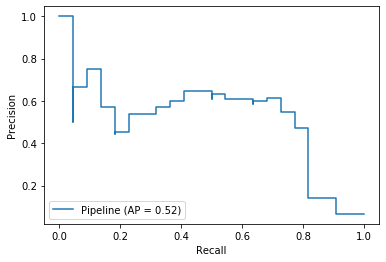

In [33]:
base_roc = plot_precision_recall_curve(base_rf, X_test, y_test)

## 2 Random Forest with missing values indicators

In [34]:
param_grid = { 
    'classifier__n_estimators': [200],
    'classifier__max_features': Integer(1, 10),
    'classifier__max_depth' : Integer(1, 5)
}

In [35]:
pipe = Pipeline([('imputation', SimpleImputer(strategy='most_frequent')),
                 ('classifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1))])

In [36]:
rf_grid = BayesSearchCV(estimator=pipe,
                        search_spaces=param_grid,
                        scoring='roc_auc',
                        n_jobs=-1).fit(X_train_with_indicators, y_train)

In [37]:
rf_best_indicators = rf_grid.best_estimator_

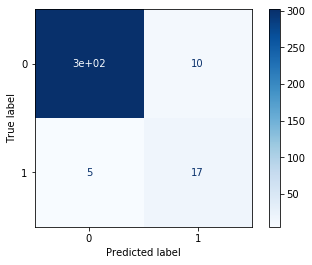

In [38]:
plot_confusion_matrix(rf_best_indicators, X_test_with_indicators, y_test, cmap='Blues')

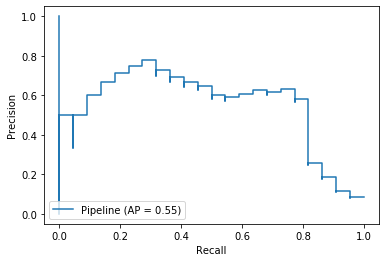

In [39]:
rf_best = plot_precision_recall_curve(rf_best_indicators, X_test_with_indicators, y_test)

Refitting best model on all training data with more trees causes slight improvements 

In [40]:
rf_best_indicators.set_params(classifier__n_estimators = 10000)

Pipeline(memory=None,
         steps=[('imputation',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=5,
                                        max_features=10, max_leaf_nodes=None,
                                        max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10000, n_jobs=-1,
                  

In [41]:
best_model_refitted = rf_best_indicators.fit(X_train_with_indicators, y_train)

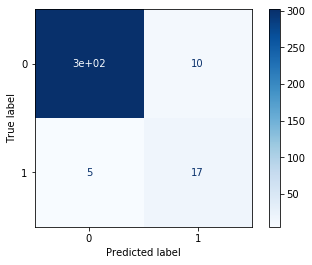

In [42]:
plot_confusion_matrix(best_model_refitted, X_test_with_indicators, y_test, cmap='Blues')

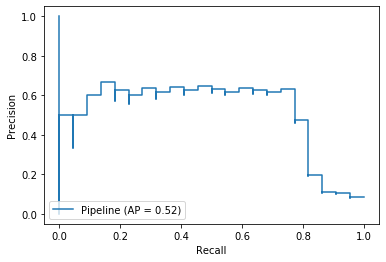

In [43]:
plot_precision_recall_curve(best_model_refitted, X_test_with_indicators, y_test)

## 3 Logistic regression with missing values indicators

In [44]:
pipe = Pipeline([('imputation', SimpleImputer(strategy='most_frequent')),
                 ('classifier', LogisticRegression(solver='saga'))])

In [45]:
param_grid = [{
    'classifier__penalty': ['none', 'l2', 'l1'],
    'classifier__C': np.logspace(0, 4, 10),
    'classifier__class_weight' : ['balanced']
}]

In [46]:
log_reg_grid_indicators = BayesSearchCV(estimator=pipe,
                                        search_spaces=param_grid,
                                        scoring='roc_auc',
                                        n_jobs=-1).fit(X_train_with_indicators, y_train)

In [47]:
log_reg_best_indicators = log_reg_grid_indicators.best_estimator_

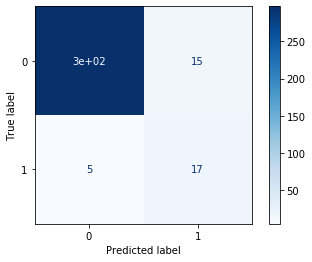

In [48]:
plot_confusion_matrix(log_reg_best_indicators, X_test_with_indicators, y_test, cmap='Blues')

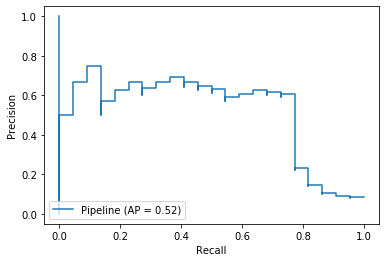

In [49]:
plot_precision_recall_curve(log_reg_best_indicators, X_test_with_indicators, y_test)

## 4 Lasso with upsampling and missing values indicators

In [50]:
pipe = Pipeline([('imputation', SimpleImputer(strategy='most_frequent')),
                 ('upsampling', RandomOverSampler()),
                 ('classifier', LogisticRegression(solver='liblinear'))])

In [51]:
param_grid = [{
    'classifier__penalty': ['l1'],
    'classifier__C': np.logspace(0, 4, 10),
    'classifier__class_weight' : ['balanced']
}]

In [52]:
lasso_grid_upsample_indicators = BayesSearchCV(estimator=pipe,
                                               search_spaces=param_grid,
                                               scoring='roc_auc',
                                               n_jobs=-1).fit(
                                                   X_train_with_indicators,
                                                   y_train)

In [53]:
lasso_best_upsample_indicators = lasso_grid_upsample_indicators.best_estimator_

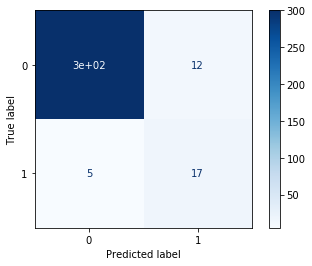

In [54]:
plot_confusion_matrix(lasso_best_upsample_indicators, X_test_with_indicators, y_test, cmap='Blues')

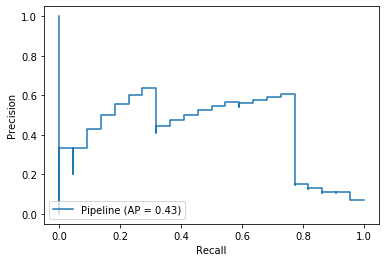

In [55]:
plot_precision_recall_curve(lasso_best_upsample_indicators, X_test_with_indicators, y_test)

Many coeficcients were reduced to zero, suggesting that they are not predictive.

In [56]:
for col, coeff in zip(X_train_with_indicators.columns, lasso_best_upsample_indicators[2].coef_[0]):
    if coeff == 0:
        print(col, round(coeff, 4))

Hormonal Contraceptives 0.0
IUD 0.0
STDs 0.0
STDs (number) 0.0
STDs:condylomatosis 0.0
STDs:vaginal condylomatosis 0.0
STDs:vulvo-perineal condylomatosis 0.0
STDs:syphilis 0.0
STDs:pelvic inflammatory disease 0.0
STDs:molluscum contagiosum 0.0
STDs:HIV 0.0
STDs:Hepatitis B 0.0
STDs:HPV 0.0
STDs: Number of diagnosis 0.0
Dx:Cancer 0.0
Dx:CIN 0.0
Dx:HPV 0.0
Dx 0.0
Number of sexual partners_indicator 0.0
First sexual intercourse_indicator 0.0
Num of pregnancies_indicator 0.0
Smokes_indicator 0.0
Smokes (years)_indicator 0.0
Smokes (packs/year)_indicator 0.0
Hormonal Contraceptives (years)_indicator 0.0
IUD_indicator 0.0
IUD (years)_indicator 0.0
STDs_indicator 0.0
STDs (number)_indicator 0.0
STDs:condylomatosis_indicator 0.0
STDs:vaginal condylomatosis_indicator 0.0
STDs:vulvo-perineal condylomatosis_indicator 0.0
STDs:syphilis_indicator 0.0
STDs:pelvic inflammatory disease_indicator 0.0
STDs:genital herpes_indicator 0.0
STDs:molluscum contagiosum_indicator 0.0
STDs:HIV_indicator 0.0
STDs:

# Feature importance

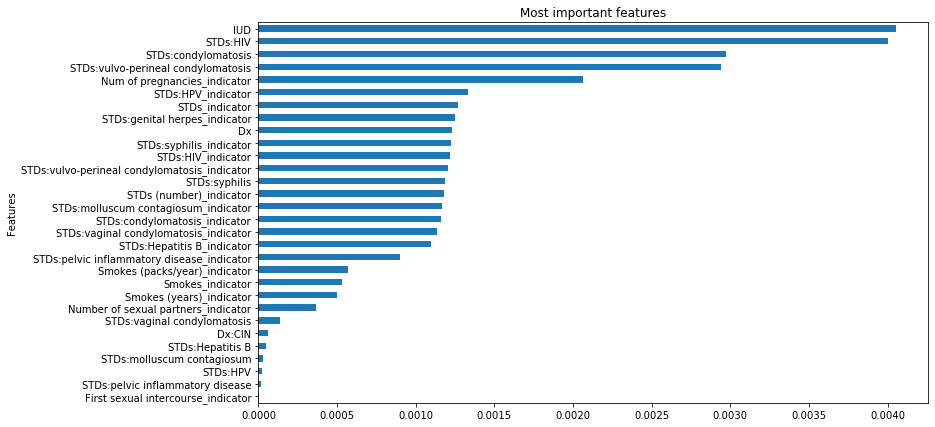

In [57]:
def rf_feat_importance(m, df):
    """
    m - trained Tree-based model
    df - X_train dataset used to train model m
    """
    return pd.DataFrame({'Features'    : df.columns, 
                         'Importance' : m.feature_importances_
                        }).sort_values('Importance', ascending=True)

fi = rf_feat_importance( rf_best_indicators[1], X_train_with_indicators)

def plot_fi(fi):
    return fi.plot('Features', 'Importance', 'barh', figsize=(12,7), legend=False,title="Most important features" )

plot_fi(fi.head(30))